In [1]:
module ExampleAdaptiveTimeCDR
using GradientRobustMultiPhysics
using ExtendableGrids
using GridVisualize
using ExtendableSparse
using Printf

"""
    ReactionConvectionDiffusionOperator(α, β, ϵ)

TBW
"""
function ReactionConvectionDiffusionOperator(α, β, ϵ)
    function action_kernel!(result, input, x, t)
        β.x = x
        β.time = t
        eval_data!( α )
        eval_data!( β )
        # α * u_h + β_1 * ∇_xu_h + β_2 ∇_y u_h
        result[1] = α.val[1] * input[1] + β.val[1] * input[2] + β.val[2] * input[3]
        # Laplacian
        result[2] = ϵ * input[2]
        result[3] = ϵ * input[3]
        return nothing
    end
    action = Action(action_kernel!, [3, 3], dependencies = "XT", bonus_quadorder = max(α.bonus_quadorder, β.bonus_quadorder))
    return BilinearForm([OperatorPair{Identity, Gradient}, OperatorPair{Identity, Gradient}], action;
    name=" ϵ(∇ u, ∇ v) + (α u + β⋅∇u, v)", transposed_assembly = true)
  end

"""
    get_problem_data(ν)

TBW
"""
function get_problem_data(ν)
    α = DataFunction([0.0]; name = "α")
    β = DataFunction([0.0,0.0]; name = "β")    
    function exact!(result, x, t)
        result[1] = 1 + x[1]^2 + x[2]^2 + 1.2*t^3
     end
    
    u = DataFunction(exact!, [1,2]; name="u", dependencies="XT", bonus_quadorder=5)
    dt_u = eval_dt(u)
    ∇u = eval_∇(u)
    Δu = eval_Δ(u)
    function rhs!(result, x, t)    
        dt_u = 1.2*3*t^2
        result[1] = dt_u-ν*Δu(x,t)[1] + dot(β(), ∇u(x,t))[1] + dot(α(), u(x,t)[1]) # α * u(x,t)[1]
      return nothing
    end
    f = DataFunction(rhs!, [1,2]; name = "f", dependencies = "XT", bonus_quadorder = 5)
    return α, β, u, ∇(u), f
  end

"""
    main(; scheme = 1, ϵ = 1, verbosity = 0, nlevels=2, T0 = 0, Tf=1, nsteps=10)

TBW
"""
function main(; scheme = 1, ϵ = 1, verbosity = 0, nlevels=2, T0 = 0, Tf=1, nsteps=10)
  ## set log level
  set_verbosity(verbosity)
  ## load initial mesh
  xgrid = grid_unitsquare(Triangle2D)
  # choose a finite element type
  FEType = H1Pk{1,2,2}
  #TODO: fix from the problem data
  u0 = DataFunction([0.0])
    
  ## negotiate data functions to the package
  α, β, u, ∇u, f = get_problem_data(ϵ)
    
  FES = FESpace{FEType}(xgrid)
  for level = 1 : nlevels
    # refine the grid 
    xgrid = uniform_refine(xgrid)

    # generate FE spaces
    FES = FESpace{FEType}(xgrid)
  end
  # @show FES
  Solution = FEVector(FES)
  n_dofs = FES.ndofs
  interpolate!(Solution[1], u; time = 0.0)
  Solnm1 = FEVector(FES)
  interpolate!(Solnm1[1], u; time = 0.0)
  Solnm2 = FEVector(FES)
  interpolate!(Solnm2[1], u; time = 1e-9)
  

  M = FEMatrix(FES)
  assemble_operator!(M[1,1], BilinearForm([Identity, Identity]))
  # @show M.entries
  # println(size(M[1,1]))
  println("ndofs: ", FES.ndofs)
  A = FEMatrix(FES)
  assemble_operator!(A[1,1], ReactionConvectionDiffusionOperator(α, β, ϵ); time=0.0)
  # @show A.entries

  rhs = FEVector(FES)
  assemble_operator!(rhs[1], LinearForm(Identity, f); time=0.0)
  # @show rhs.entries

  dt = Array{BoundaryData,1}(undef,0)
  push!(dt, BoundaryData(BestapproxDirichletBoundary; regions = [1,2,3,4], data = u))
  dofs = boundarydata!(Solution[1], dt; time = 0.0)

  t0 = T0
  if scheme == 1
      tau = (Tf - T0)/nsteps
  end
  if scheme == 2
      tau = (Tf - T0)/nsteps
  end
    
  V1 = zeros(Float64, FES.ndofs, 1)
  Mu0 = zeros(Float64, FES.ndofs)    

  SystemMatrix = FEMatrix(FES)
  # @show SystemMatrix
  SystemRHS = FEVector(FES)
  SystemSol = FEVector(FES)
  
  step = one(Int)

  l2max = -one(Float64)
  first_step  = true
# --------------------------Time step start -----------------------------------------------------------
  nts = 1
  oldL2 = zero(Float64); oldh1 = zero(Float64)
  eL2 = zero(Float64); eh1 = zero(Float64)
  while t0 <= Tf-1e-10
    t0 = t0 + tau
    fill!(SystemRHS.entries, 0)
    fill!(rhs.entries, 0)
    assemble_operator!(rhs[1], LinearForm(Identity, f), time= t0 )
    V1[:, 1] = rhs.entries

    fill!(SystemMatrix.entries.cscmatrix.nzval, 0)
    fill!(A.entries.cscmatrix.nzval, 0)
    if nts == 1
      if scheme == 2
        @info("First step with BDF1")
      end      
      #first step by bdf1
      addblock!(SystemRHS[1], M.entries*Solution[1].entries; factor= 1.0/tau)
      addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )
      
      assemble_operator!(A[1, 1], ReactionConvectionDiffusionOperator(α, β, ϵ); time=t0 )
      addblock!(SystemMatrix[1, 1], M[1, 1]; factor= 1.0/tau)
      addblock!(SystemMatrix[1, 1], A[1, 1]; factor= 1.0)
    else
      #bdf2 scheme, prepare the systemrhs
      addblock!(SystemRHS[1], M.entries*Solnm1[1].entries; factor=   2.0/tau)
      addblock!(SystemRHS[1], M.entries*Solnm2[1].entries; factor=  -0.5/tau)
      addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )

      # system matrix 
      assemble_operator!(A[1, 1], ReactionConvectionDiffusionOperator(α, β, ϵ); time=t0 )
      addblock!(SystemMatrix[1, 1], M[1, 1]; factor= 1.5/tau)
      addblock!(SystemMatrix[1, 1], A[1, 1]; factor= 1.0)
    end
    dofs = boundarydata!(SystemSol[1], dt; time = t0)        
    for dof in dofs
      SystemRHS[1][dof] = 1e60 * SystemSol[1][dof]
      SystemMatrix[1,1][dof,dof] = 1e60
    end
    flush!(SystemMatrix.entries)      
    #@show SystemRHS.entries
      
    SystemSol.entries[:] = SystemMatrix.entries \ SystemRHS.entries

    for j = 1 : n_dofs 
      Solution[1][j] = SystemSol[1][j]
    end

    L2Error_u = L2ErrorIntegrator(u, Identity; time= t0)
    l2 = evaluate(L2Error_u, Solution[1])
    eL2 += (l2 + oldL2) * tau * 0.5
    oldL2 = l2

    h1erro = L2ErrorIntegrator(∇(u), Gradient; time= t0)
    h1 = evaluate(h1erro, Solution[1])
    eh1 += (l2 + oldh1) * tau * 0.5
    oldh1 = h1
    #@printf("it:%d: [%.5f, %.5e, %5.5e]\n", nts, t0, l2, l2)
    if scheme == 2
      nts = nts + 1
      for j=1:n_dofs 
        Solnm2[1][j] = Solnm1[1][j]
        Solnm1[1][j] = Solution[1][j]
      end
    end    
  end
  println("L2(0,t,L2): ", sqrt(eL2))
  println("L2(0,t,H1): ", sqrt(eh1))
    # println("L2(0,t,H1): ", sqrt(eH1))
    # println("L_inf(L2): ", sqrt(l2max))
  (sqrt(eL2), sqrt(eh1))
  end #end Main Function
end

Main.ExampleAdaptiveTimeCDR

In [2]:
ns = [10 20 40 80 160]
eL2=[]; eH1=[];
for n in ns
    el2, eh1 = Main.ExampleAdaptiveTimeCDR.main(scheme=2, nsteps=n)
    push!(eL2, el2)
    push!(eH1, eh1)
end

┌ Warning:  38617442 allocations during ExtendableGrids.ITEMTYPE_FACE volume calculation
└ @ ExtendableGrids ~/.julia/packages/ExtendableGrids/XFxI3/src/derived.jl:937
ndofs: 

145


[ Info: First step with BDF1
L2(0,t,L2): 

0.00093605625837323
L2(0,t,H1): 0.003003429791860748
ndofs: 145
[ Info: First step with BDF1
L2(0,t,L2): 

0.0002366022138014985
L2(0,t,H1): 0.0007695002691677155
ndofs: 145
[ Info: First step with BDF1
L2(0,t,L2): 

5.9385202162132434e-5
L2(0,t,H1): 0.00019438893000760173
ndofs: 145
[ Info: First step with BDF1
L2(0,t,L2): 

1.4864323087132987e-5
L2(0,t,H1): 4.8810983573822014e-5
ndofs: 145
[ Info: First step with BDF1
L2(0,t,L2): 

3.717303853524484e-6
L2(0,t,H1): 1.2225995613939666e-5


L2: Any[0.00093605625837323, 0.0002366022138014985, 5.9385202162132434e-5, 1.4864323087132987e-5, 3.717303853524484e-6]
H1: Any[0.003003429791860748, 0.0007695002691677155, 0.00019438893000760173, 4.8810983573822014e-5, 1.2225995613939666e-5]


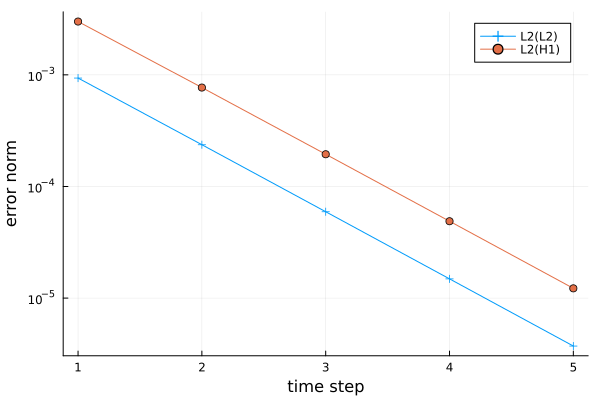

In [5]:
using Plots
println("L2: ", eL2)
println("H1: ", eH1)
taus = [ 1,2,3,4,5]
plot(taus,[eL2 eH1],
    yaxis=:log10,
    label=["L2(L2)" "L2(H1)"],
    shape=:auto,
    xlabel="time step",ylabel="error norm")

In [4]:
println(log2(0.004595049094968035/0.002336073094951425))
println(log2(0.002336073094951425/0.0011783641241968105))

0.9759948594370211
0.9873000036896975


In [5]:
println(log2(0.00093605625837323/0.0002366022138014985))
println(log2(0.0002366022138014985/5.9385202162132434e-5))
println(log2(5.9385202162132434e-5/1.4864323087132987e-5))

1.9841316680144376
1.9942881880113572
1.9982497141683153


it:1: [0.10000, 1.08836e-05, 1.08836e-05]